# RNA-seq Calling 

This pipeline aims to call the RNA-seq data from original `fastq.gz` data. It implements the GTEx pipeline for TOPMed project. Please refer to [this page](https://github.com/broadinstitute/gtex-pipeline/blob/master/TOPMed_RNAseq_pipeline.md) for detail.

**Various reference data needs to be prepared before using this workflow**. [Here we provide a module](../../data_preprocessing/reference_data.html) to download and prepare the reference data. 

## Methods overview

> ../../../images/rna_quantification.png (66.6 KiB):

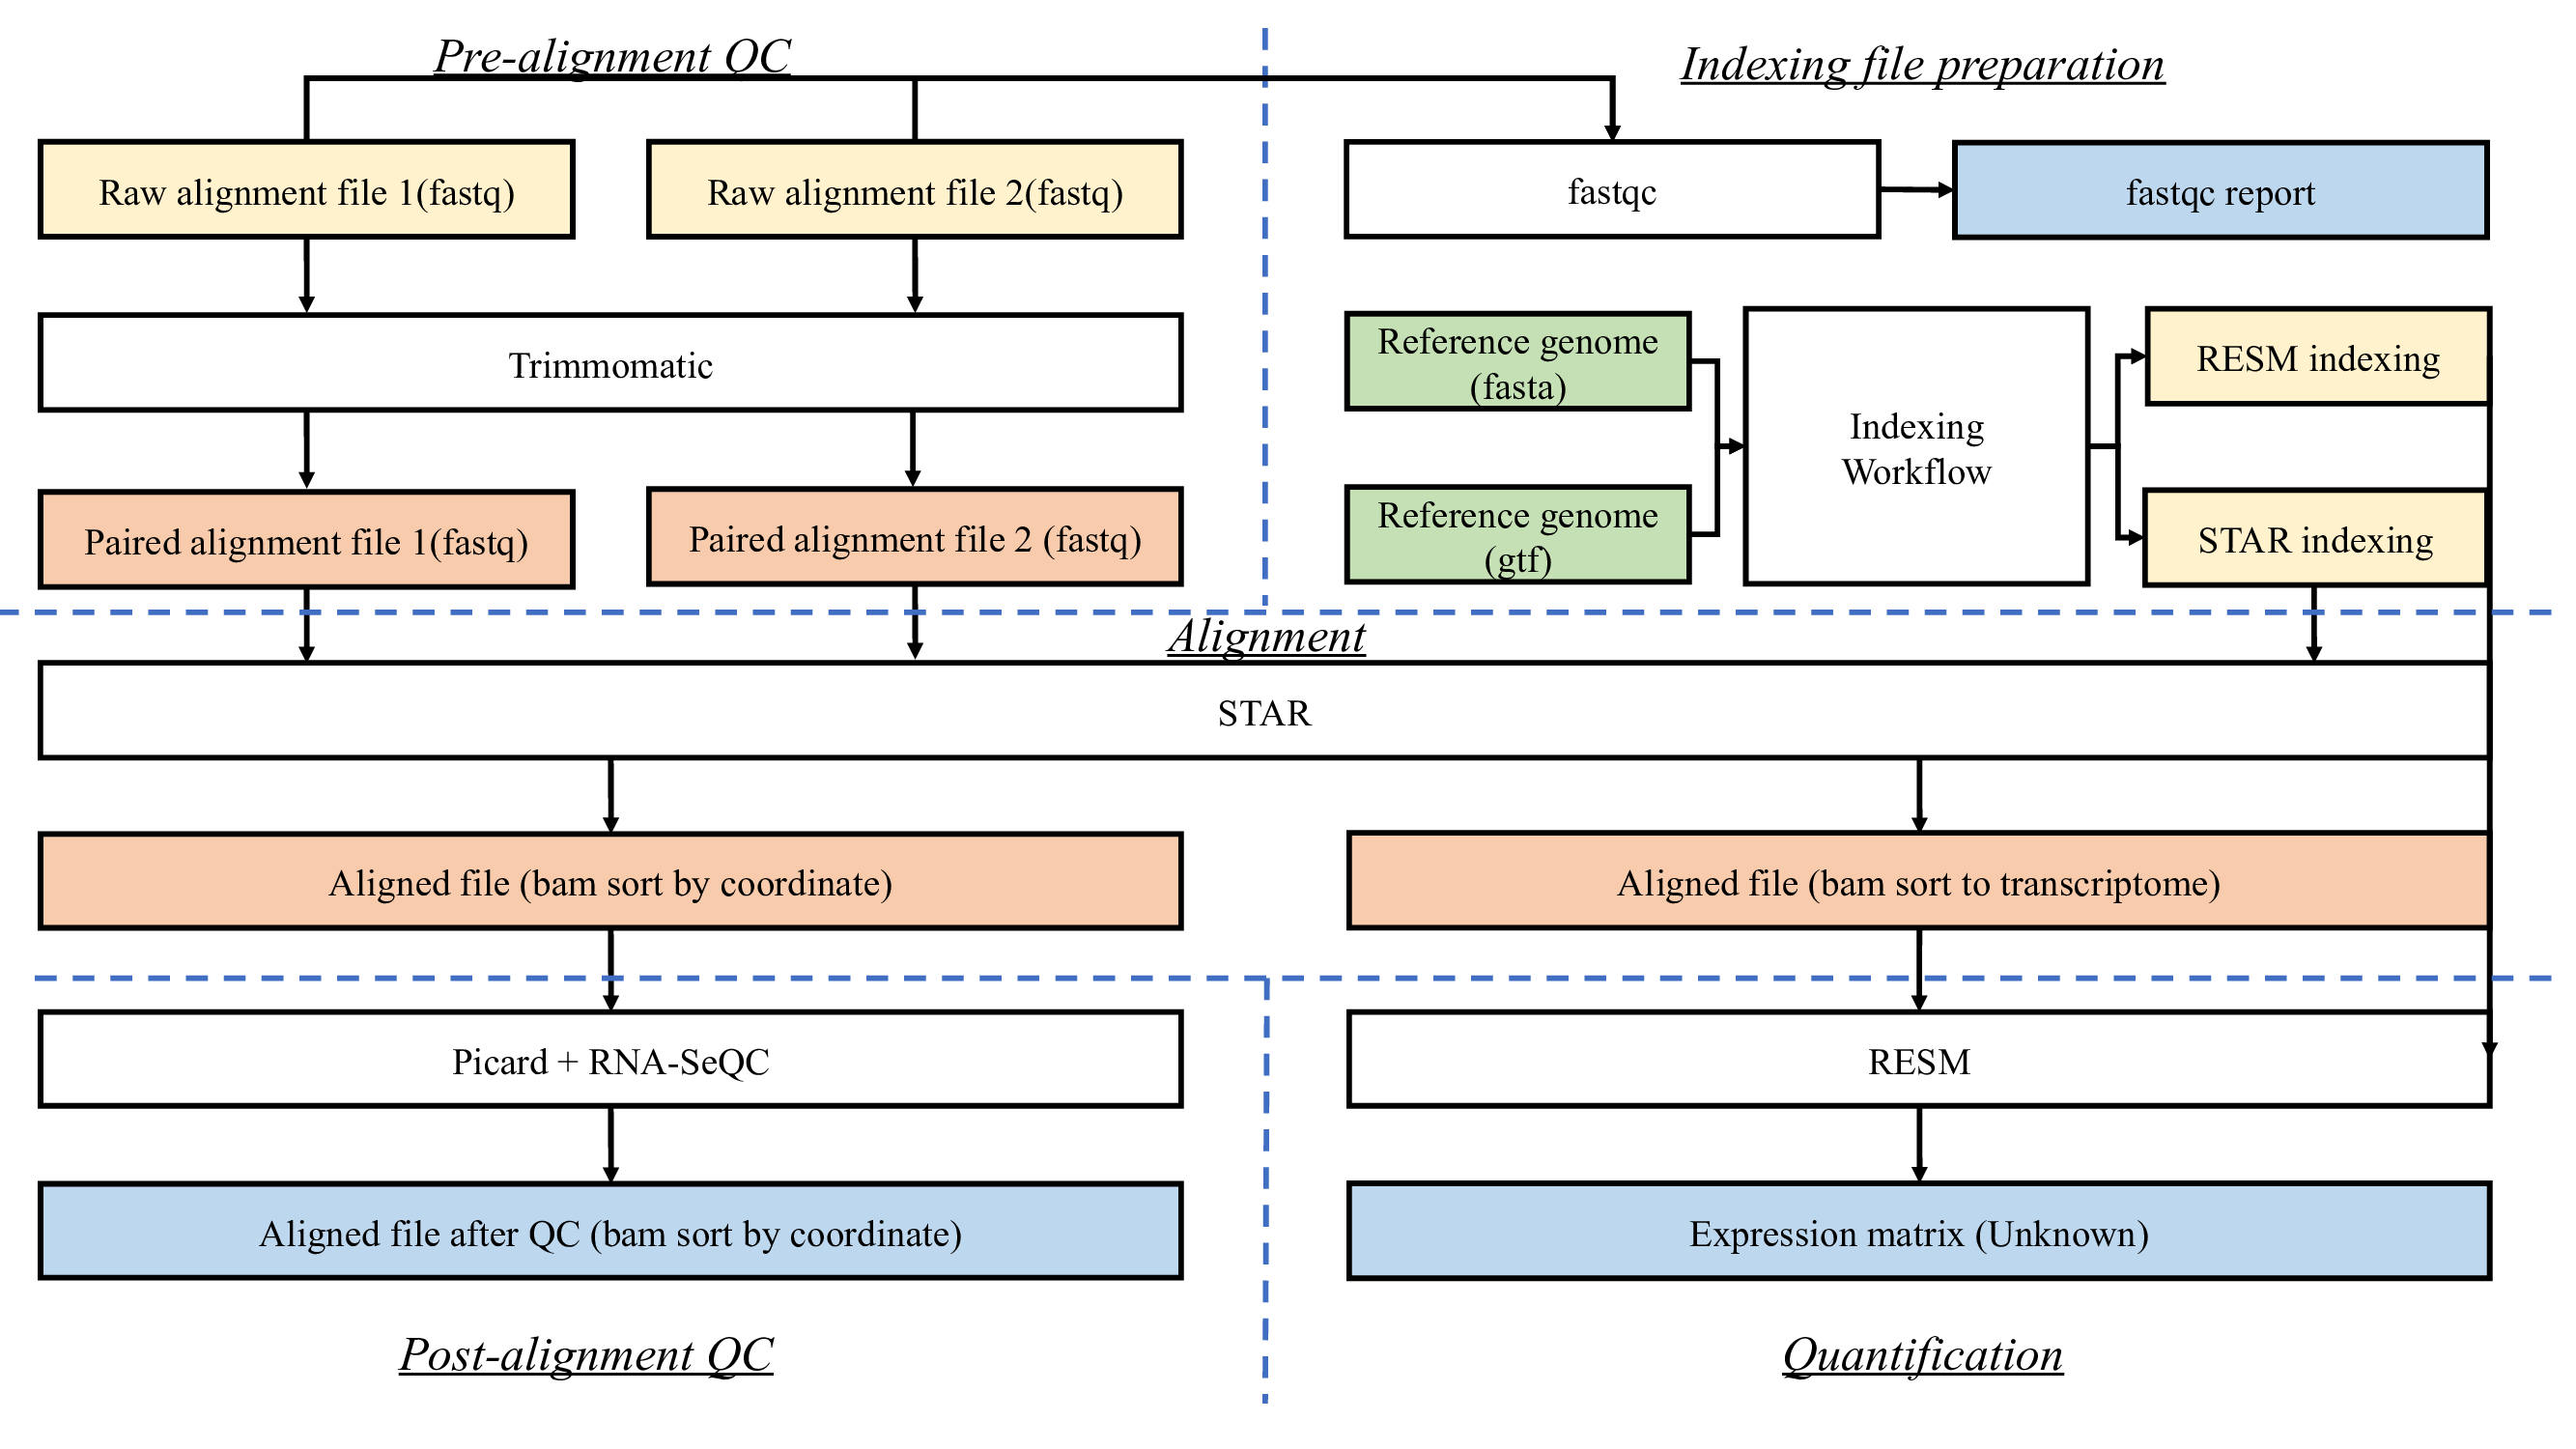

In [4]:
%preview ../../../images/rna_quantification.png

## Minimal working example

A toy `fastq` data can be found on [Google Drive](https://drive.google.com/drive/u/0/folders/11kQv7PXozsKkgeqADH-28bC_kZ-w_oHo).

To generate `fastqc` report,

**FIXME: make sure this works**

In [ ]:
sos run RNA_calling.ipynb fastqc \
    --fastq1 data/samp1_r1.fq.gz \
    --fastq2 data/samp1_r2.fq.gz \
    --sample_id samp1 \
    --container container/rna_quantification.sif

To call gene-level RNA expression using `rnaseqc`,

In [ ]:
sos run RNA_calling.ipynb rnaseqc_call \
    --fastq1 data/samp1_r1.fq.gz \
    --fastq2 data/samp1_r2.fq.gz \
    --sample_id samp1 \
    --STAR-index reference_data/STAR_Index/ \
    --gtf reference_data/Homo_sapiens.GRCh38.103.chr.reformated.collapsed.reformated.gtf \
    --container container/rna_quantification.sif

To call transcript level RNA expression using `RSEM`,

In [ ]:
sos run RNA_calling.ipynb rsem_call \
    --fastq1 data/samp1_r1.fq.gz \
    --fastq2 data/samp1_r2.fq.gz \
    --sample_id samp1 \
    --STAR-index reference_data/STAR_Index/ \
    --RSEM-index reference_data/RSEM_Index/ \
    --container container/rna_quantification.sif

## Command interface

In [9]:
sos run RNA_calling.ipynb -h

usage: sos run RNA_calling.ipynb [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  fastqc
  rnaseqc_call
  rsem_call
  remove_adaptor
  STAR_align

Global Workflow Options:
  --wd . (as path)
                        The output directory for generated files. MUST BE FULL
                        PATH
  --job-size 1 (as int)
                        For cluster jobs, number commands to run per job
  --walltime 5h
                        Wall clock time expected
  --mem 16G
                        Memory expected
  --numThreads 8 (as int)
                        Number of threads
  --container ''
                        Software container option
  --fastq1 VAL (as path, required)
           

## Setup and global parameters

In [6]:
[global]
# The output directory for generated files. MUST BE FULL PATH
parameter: cwd = path
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Wall clock time expected
parameter: walltime = "5h"
# Memory expected
parameter: mem = "16G"
# Number of threads
parameter: numThreads = 8
# Software container option
parameter: container = ""
# Raw data
parameter: fastq1 = path
parameter: fastq2 = path
# Sample ID
parameter: sample_id = str
# Is the RNA-seq data stranded
parameter: is_stranded = False
from sos.utils import expand_size
cwd = path(f'{cwd:a}')

## Step 0: QC before alignment

This step utilize `fastqc` and will generate two QC report in `html` format

### Step Inputs

* `fastq1` and `fastq2`: paths to original `fastq.gz` file.

### Step Outputs
* Two `html` file for QC report

In [7]:
[fastqc]
fastq_raw = [fastq1, fastq2]
input: for_each = "fastq_raw"
output: f'{cwd}/{_input:bnn}_fastqc.html',f'{cwd}/{_input:bnn}_fastqc/fastqc_data.txt' 
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads
bash: expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout', container=container
    fastqc ${_input} -o ${_output[0]:d}
    unzip ${_output[0]:n}.zip

## Step 1: Remove adaptor through `Trimmomatic`

Documentation: [Trimmomatic](http://www.usadellab.org/cms/?page=trimmomatic)

### Step Inputs

* `fastq1_raw` and `fastq2_raw`: paths to original `fastq.gz` file.
* `soft_dir`: directory for the software
* `adapter_file`: **filename** for the adapter reference file. based on the following rules:

**FIXME: the text below is not comprehensible. Please write it formally and clearly**

```
As a rule of thumb newer libraries will 
use TruSeq3, but this really depends on your service provider.
If you use FASTQC, the „Overrepresented Sequences‟ report can help indicate which adapter 
file is best suited for your data. 
“Illumina Single End” or “Illumina Paired End” sequences indicate single-end or paired-end 
TruSeq2 libraries, and the appropriate adapter files are “TruSeq2-SE.fa” and “TruSeq2-PE.fa” 
respectively. 
“TruSeq Universal Adapter” or “TruSeq Adapter, Index …” indicates TruSeq-3 libraries, and 
the appropriate adapter files are “TruSeq3-SE.fa” or “TruSeq3-PE.fa”, for single-end and 
paired-end data respectively. 
Adapter sequences for TruSeq2 multiplexed libraries, indicated by “Illumina Multiplexing 
…”, and the various RNA library preparations are not currently included.
```

### Step Outputs
* Two paired `fastq.gz` file for alignment
* Two unpaired `fastq.gz` 

In [1]:
[rnaseqc_call_1, rsem_call_1, remove_adaptor]
# Path to the software. Default set to using our rna_quantification.sif image
parameter: soft_jar = "/opt/Trimmomatic-0.39/trimmomatic-0.39.jar"
# Path to the reference adaptors:
parameter: adapter_file = "TruSeq3-PE.fa"
parameter: maximum_mismatch_count = 2
parameter: palindrome_clip_threshold = 30
parameter: simple_clip_threshold = 10
# FIXME: Other parameters (i.e. leading, trailing ... )
input: fastq1, fastq2
output: fq_1 = f'{cwd}/{sample_id}_paired_{_input[0]:bn}.gz',
        fq_1_up = f'{cwd}/{sample_id}_unpaired_{_input[0]:bn}.gz',
        fq_2 = f'{cwd}/{sample_id}_paired_{_input[1]:bn}.gz',
        fq_2_up = f'{cwd}/{sample_id}_unpaired_{_input[1]:bn}.gz'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads
bash: container=container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    java -jar ${software_jar} PE -threads ${numThreads} \
        ${_input[0]} \
        ${_input[1]} \
        ${_output[0]} \
        ${_output[1]} \
        ${_output[2]} \
        ${_output[3]} \
        ILLUMINACLIP:${adapter_file}:${maximum_mismatch_count}:${palindrome_clip_threshold}:${simple_clip_threshold} \
        LEADING:3 TRAILING:3 SLIDINGWINDOW:4:20 MINLEN:50

## Step 2: Alignment through `STAR`

Documentation : [STAR](https://github.com/alexdobin/STAR) and [Script in docker](https://github.com/broadinstitute/gtex-pipeline/blob/master/rnaseq/src/run_STAR.py)

This step is the main step for `STAR` alignment. 

### Step Inputs

* `fastq1` and `fastq2`: paths to clean `fastq.gz` file from Step 1.
* `STAR_index`: directory for the STAR aligment index

### Step Outputs

* bam file output `${cwd}/{sample_id}.Aligned.sortedByCoord.bam`, will be used in step 3 and 4
* bam file output `${cwd}/{sample_id}.Aligned.toTranscriptome.bam`, will be used in step 5

In [1]:
[rnaseqc_call_2, rsem_call_2, STAR_align]
# STAR indexing file
parameter: STAR_index = path
# Alignment parameter
parameter: outFilterMultimapNmax = 20 
parameter: alignSJoverhangMin = 8 
parameter: alignSJDBoverhangMin = 1 
parameter: outFilterMismatchNmax = 999 
parameter: outFilterMismatchNoverLmax = 0.1
parameter: alignIntronMin = 20 
parameter: alignIntronMax = 1000000 
parameter: alignMatesGapMax = 1000000 
parameter: outFilterType =  "BySJout" 
parameter: outFilterScoreMinOverLread = 0.33 
parameter: outFilterMatchNminOverLread = 0.33 
parameter: limitSjdbInsertNsj = 1200000 
parameter: outSAMstrandField = "intronMotif" 
parameter: outFilterIntronMotifs = "None" 
parameter: alignSoftClipAtReferenceEnds = "Yes" 
parameter: quantMode = "TranscriptomeSAM GeneCounts" 
parameter: outSAMattrRGline = "ID:rg1 SM:sm1" 
parameter: outSAMattributes = "NH HI AS nM NM ch" 
parameter: chimSegmentMin = 15 
parameter: chimJunctionOverhangMin = 15 
parameter: chimOutType =  "Junctions WithinBAM SoftClip" 
parameter: chimMainSegmentMultNmax = 1 

fail_if(expand_size(mem) < expand_size('40G'), msg = "At least 40GB of memory is required for this step")

output: cord_bam = f'{cwd}/{sample_id}.Aligned.sortedByCoord.bam',
        trans_bam = f'{cwd}/{sample_id}.Aligned.toTranscriptome.bam'

task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads
bash: container=container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    run_STAR.py \
        ${STAR_index} ${_input["fq_1"]} ${_input["fq_2"]} ${sample_id} \
        --output_dir ${cwd} \
        --outFilterMultimapNmax ${outFilterMultimapNmax} \
        --alignSJoverhangMin ${alignSJoverhangMin} \
        --alignSJDBoverhangMin ${alignSJDBoverhangMin} \
        --outFilterMismatchNmax ${outFilterMismatchNmax} \
        --outFilterMismatchNoverLmax ${outFilterMismatchNoverLmax} \
        --alignIntronMin ${alignIntronMin} \
        --alignIntronMax ${alignIntronMax} \
        --alignMatesGapMax ${alignMatesGapMax} \
        --outFilterType ${outFilterType} \
        --outFilterScoreMinOverLread ${outFilterScoreMinOverLread} \
        --outFilterMatchNminOverLread ${outFilterMatchNminOverLread} \
        --limitSjdbInsertNsj ${limitSjdbInsertNsj} \
        --outSAMstrandField ${outSAMstrandField} \
        --outFilterIntronMotifs ${outFilterIntronMotifs} \
        --alignSoftClipAtReferenceEnds ${alignSoftClipAtReferenceEnds} \
        --quantMode ${quantMode} \
        --outSAMattrRGline ${outSAMattrRGline} \
        --outSAMattributes ${outSAMattributes} \
        --chimSegmentMin ${chimSegmentMin} \
        --chimJunctionOverhangMin ${chimJunctionOverhangMin} \
        --chimOutType ${chimOutType} \
        --chimMainSegmentMultNmax ${chimMainSegmentMultNmax} \
        --threads ${numThreads}

## Step 3: Mark duplicates reads through `Picard`

Documentation : [MarkDuplicates](https://github.com/alexdobin/STAR) and [Script in docker](https://github.com/broadinstitute/gtex-pipeline/blob/master/rnaseq/src/run_MarkDuplicates.py)

This step is the first QC step after `STAR` alignment. This step maily remove duplications in `bam` file output by STAR.


### Step Inputs:

* `STAR_bam`: path to the output in Step 2.

### Step Outputs:

* A new `.bam` file with duplication marked with the hexadecimal value of `0x0400`, which corresponds to a decimal value of 1024

This step can be automatically ran while calling RSEM/RNA_QC

In [8]:
[rnaseqc_call_3]
output: f'{cwd}/{sample_id}.Aligned.sortedByCoord.md.bam'
bash: container=container, expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout'
        run_MarkDuplicates.py ${_input["cord_bam"]} ${sample_id}

## Step 4: Post aligment QC through `RNA-SeQC`

Documentation : [RNA-SeQC](https://github.com/getzlab/rnaseqc) and [Script in docker](https://github.com/broadinstitute/gtex-pipeline/blob/master/rnaseq/src/run_rnaseqc.py)

This step is second QC step after `STAR` alignment. It will perform RNA-seq quantification as well. 

### Step Inputs

* `QC_bam`: path to the output in Step 3.
* `gtf`: reference genome `.gtf` file, this gtf file need to have the same chr name format as the index used to generate the bam file and must be on collapsed gene gtf 

### Step Outputs


The following output files are generated in the output directory you provide:

* {sample}.metrics.tsv : A tab-delimited list of (Statistic, Value) pairs of all statistics and metrics recorded.

* {sample}.exon_reads.gct : A tab-delimited GCT file with (Exon ID, Gene Name, coverage) tuples for all exons which had at least part of one read mapped.

* {sample}.gene_reads.gct : A tab-delimited GCT file with (Gene ID, Gene Name, coverage) tuples for all genes which had at least one read map to at least one of its exons

* {sample}.gene_tpm.gct : A tab-delimited GCT file with (Gene ID, Gene Name, TPM) tuples for all genes reported in the gene_reads.gct file. Note: this file is renamed to .gene_rpkm.gct if the --rpkm flag is present.

* {sample}.fragmentSizes.txt : A list of fragment sizes recorded, if a BED file was provided

* {sample}.coverage.tsv : A tab-delimited list of (Gene ID, Transcript ID, Mean Coverage, Coverage Std, Coverage CV) tuples for all transcripts encountered in the GTF.

### `stranded` option

If you have strand-specific data, specify the library type. There are four library types:

Paired reads:
- RF: first read (/1) of fragment pair is sequenced as anti-sense (reverse(R)), and second read (/2) is in the sense strand (forward(F)); typical of the dUTP/UDG sequencing method.
- FR: first read (/1) of fragment pair is sequenced as sense (forward), and second read (/2) is in the antisense strand (reverse)

Unpaired (single) reads:
- F: the single read is in the sense (forward) orientation
- R: the single read is in the antisense (reverse) orientation

**FIXME: please list all outputs in `output`**

In [10]:
[rnaseqc_call_4]
# Reference gene model
parameter: gtf = path
# Default empty for unstranded. Options are fr or rf
parameter: stranded = ""
output: f'{cwd}/{sample_id}.gene_tpm.gct.gz'
bash: container=container, expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout'
    run_rnaseqc.py \
        ${gtf} \
        ${_input} \
        ${_output} ${("--stranded " + stranded) if stranded else ""}

## Step 5: Quantify expression through `RSEM`

Documentation : [RSEM](https://deweylab.github.io/RSEM/rsem-calculate-expression.html) and [Script in docker](https://github.com/broadinstitute/gtex-pipeline/blob/master/rnaseq/src/run_RSEM.py)

This step generate the expression matrix from STAR output. Estimate gene and isoform expression from RNA-Seq data are generated.

### Step Input

* transcript-level BAM file: path to the output of Step 3.
* `RSEM_index`: path to RSEM index

### Step Outputs
Please see the output section of https://deweylab.github.io/RSEM/rsem-calculate-expression.html

**FIXME: please list all outputs in `output`**

In [12]:
[rsem_call_3]
parameter: RSEM_index = path
output: f'{cwd}/{sample_id}.rsem.genes.results'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads
bash: container=container, expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout'
    run_RSEM.py \
        --max_frag_len 1000 \
        --estimate_rspd true \
        --is_stranded ${"true" if is_stranded else "false"} \
        --threads ${numThreads} \
        ${RSEM_index} ${_input["trans_bam"]:a} ${sample_id} -o ${_output:d}